In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)

True

In [19]:
#thsi code is used to hide the warning messages
pd.options.mode.chained_assignment = None

## Exploratory Data Analysis

In [2]:
df=pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Require column for model don't have null values , so we are not going to fill null values.

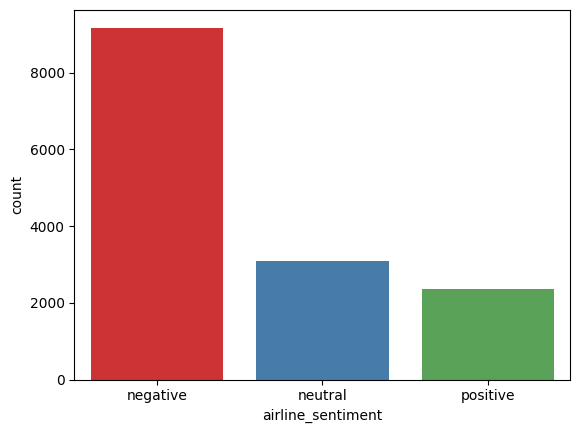

In [5]:
df_sorted = df.sort_values('airline_sentiment')
order=['negative','neutral','positive']
sns.countplot(x='airline_sentiment',data=df,order=order,palette='Set1')
plt.show()

Negative tweet count is much higher than neutral and positive

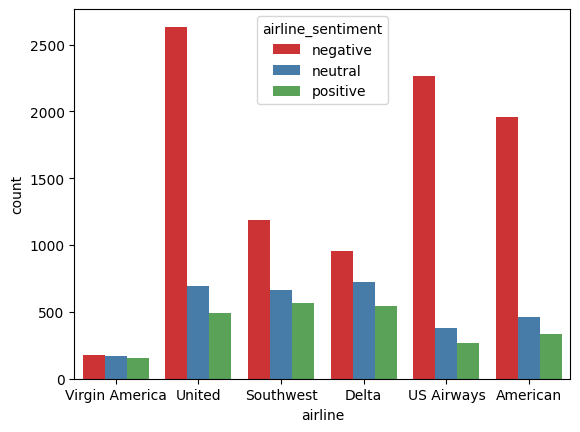

In [6]:
sns.countplot(x='airline',hue='airline_sentiment', data=df,palette='Set1',hue_order=order)
plt.show()

*United airline* has the most number of negative reviews.

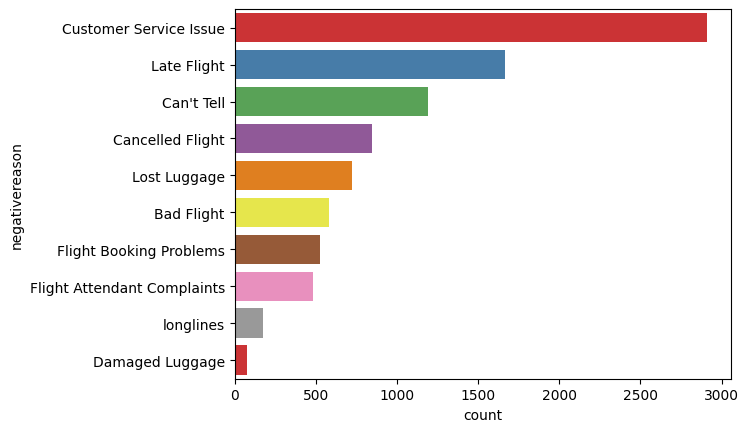

In [7]:
sns.countplot(y='negativereason',data=df,order=df['negativereason'].value_counts().index,palette='Set1')
plt.show()

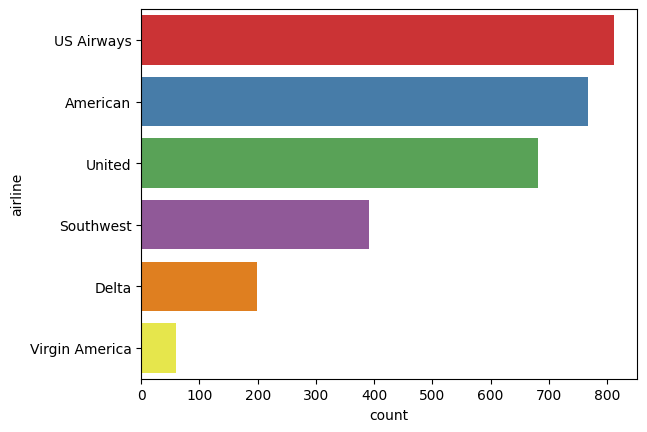

In [8]:
df_cservice=df[df['negativereason']=='Customer Service Issue']
sns.countplot(y='airline', data=df_cservice, palette='Set1',order=df_cservice['airline'].value_counts().index)
plt.show()

**Us Airways** has worst customer service

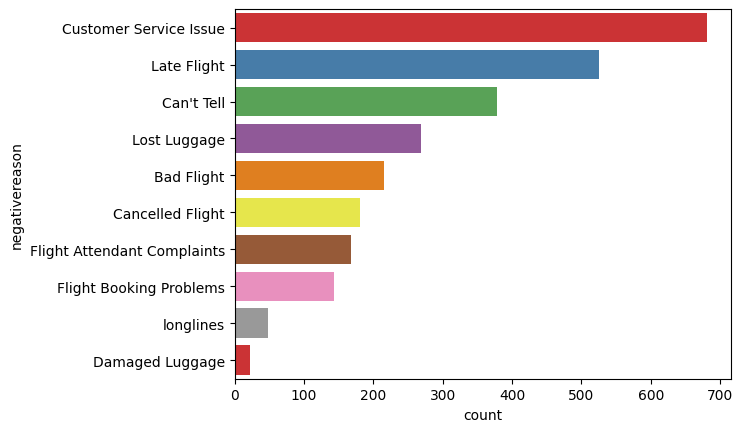

In [9]:
# Filter for United Airlines
df_united = df[df['airline'] == 'United']
sns.countplot(y='negativereason', data=df_united, palette='Set1',order=df_united['negativereason'].value_counts().index)
plt.show()

Main reason of Bad reviews of *United Airline* is also **Bad Customer service**

In [ ]:
# sns.histplot(df['airline_sentiment_confidence'])
# plt.show()

## Data Preprocessing 

In [37]:
#selecting only columns needed for sentiment analysis
df_sa=df[['airline_sentiment','text']]
df_sa.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [38]:
tweet_leanght=df['text'].apply(len)
print(f'min={min(tweet_leanght)},mean={round(np.mean(tweet_leanght))},max={max(tweet_leanght)}')

min=12,mean=104,max=186


In [46]:
#defining a function to clean the tweets
def preprocessing(text):
    #remove url
    text=re.sub(r'http\S+|www\S+|https\S+','',text,flags=re.MULTILINE)
    #remove user @ references and '#' from tweet
    text=re.sub(r'\@\w+|\#','',text)
    #removing every thing expect alphbets
    text=re.sub(r'[^a-zA-Z]',' ',text)
    
    text=text.lower()
    tokenized_text=word_tokenize(text)
    
    #remove stopwords
    stopword=stopwords.words('english')
    tokenized_text=[word for word in tokenized_text if word not in stopword]
    
    # lematizing the words
    lem=WordNetLemmatizer()
    tokenized_text=[lem.lemmatize(word) for word in tokenized_text]
    
    #using lest to diambuiguate the words
    tokenized_text = [
    (lesk(tokenized_text, word).lemmas()[0].name()
    if lesk(tokenized_text, word) else word)
    for word in tokenized_text
    ]
    
    text=' '.join(tokenized_text)
    return text

In [47]:
df_sa['text']=df_sa['text'].apply(preprocessing)
df_sa.head()

,airline_sentiment,text
0,neutral,think
1,positive,summation total commercial know tacky
2,neutral,today mustiness mean want take another travel
3,negative,aggressive smash objectionable entertainment n...
4,negative,large regretful thing


### Comapring raw and preprocessed data 

In [51]:
tweet_leanght_a=df_sa['text'].apply(len)
print(f'min={min(tweet_leanght_a)},mean={round(np.mean(tweet_leanght_a))},max={max(tweet_leanght_a)}')

min=0,mean=64,max=178


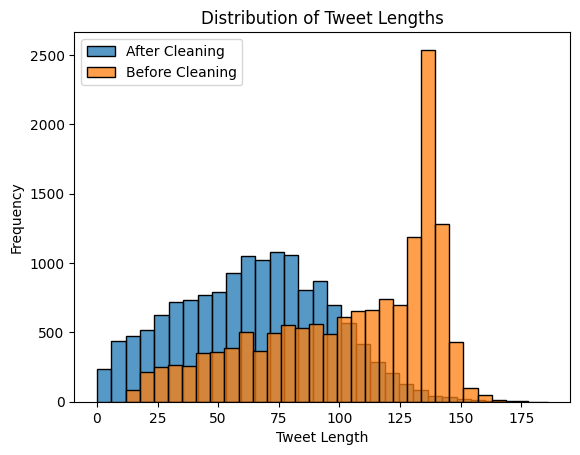

In [58]:
#plotting the distribution of tweet length

sns.histplot(tweet_leanght_a, bins=30,label='After Cleaning')
sns.histplot(tweet_leanght, bins=30,label='Before Cleaning')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

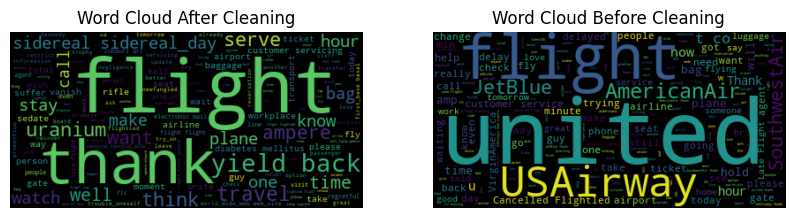

In [61]:
#creating word cloud jus for fun
# Convert the tokenized text into a single string
text = ' '.join(df['text'])
text_a = ' '.join(df_sa['text'])

# Create word clouds
wordcloud_a = WordCloud().generate(text_a)
wordcloud = WordCloud().generate(text)

# Plot the word clouds
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_a, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud After Cleaning')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud Before Cleaning')

plt.show()

### Now we will Create model for Sentiment analysis